Le but de ce TP est de manipuler des CNN dans leur scénario principal d'utilisation : la Computer Vision. Il est à noter que cette architecture peut être utilisée en NLP, en particulier lorsqu'on travaille sur des textes relativement courts, mais le mécanisme de convolution est plutôt à l'état de l'art lorsqu'on cherche à réaliser une tâche sur des images.

Nous allons réaliser un Transfer Learning sur un modèle VGG, en procédant en deux grands temps :
1. Extraction de features des images afin d'en réaliser une segmentation (apprentissage non supervisé) puis de comparer les résultats de cette segmentation avec les classes d'origine. L'idée est plutôt d'informer la faisabilité d'un moteur de classification d'images tout en étudiant au passage la pertinence du choix du référentiel de classes.
2. Classification (apprentissage supervisé) des images, avec tout d'abord une approche simple sur notre strict ensemble d'images, puis une approche avec data augmentation. La data augmentation peut être réalisée grâce à un data generator (comme illustré dans les slides) - les images sont alors directement récupérées à la volée dans le repertoire des images - ou être intégrée au modèle (layer(s) en début de modèle).

Mettre à jour au fur et à mesure la cellule suivante des imports.

In [150]:
from glob import glob
import os
import pickle as pkl
from typing import Any, Protocol, Sequence

from dotenv import load_dotenv
from matplotlib.image import imread
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, classification_report, adjusted_rand_score
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import (
    GlobalAveragePooling2D,
    Dense,
    Dropout,
    RandomFlip,
    RandomRotation,
    RandomZoom,
)
from plot_keras_history import show_history, plot_history
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import to_categorical

In [32]:
class Predictor(Protocol):
    def predict(self, args: Any, **kwargs: Any) -> Any:
        ...

# TEMPS 1 : SEGMENTATION

## Préparation du dataset

<font color="purple">Récupérer le chemin du dossier contenant les images du fichier .env.</font>

In [33]:
load_dotenv()
IMG_FOLDER = os.getenv("TP2_IMG_FOLDER")

<font color="purple">Initialiser une constante contenant la liste référentielle des labels possibles.</font>

In [34]:
LABELS_LIST = ["cloudy", "rain", "shine", "sunrise"]

<font color="purple">En observation la convention de nommage des fichiers images, écrire une fonction (efficace) permettant de déterminer le label d'une photo à partir du nom du fichier.</font>

In [35]:
def get_image_label(
    img_filename: str,
    possible_labels: Sequence[str]|None = None,
    label_not_found_value: str = "unknown",
) -> str:
    """Extract the label from the name of the image file."""
    if possible_labels is None:
        possible_labels = LABELS_LIST
    for label in possible_labels :
        if label in img_filename:
            return label
    return label_not_found_value

<font color="purple">Ecrire une fonction créant un dataframe pandas contenant le chemin vers l'image et le label. Construire le dataframe associé à notre jeu de données.</font>

In [36]:
def create_data_from_img_files(path: str = IMG_FOLDER) -> pd.DataFrame:
    """Create a DataFrame containing all the paths to the images as well
    as the labels of these images.
    """
    images_list = glob(f"{path}*\*.jp*")  # in case some files are not jpg or jpeg files
    df_out = pd.DataFrame(data={"image_path": images_list})
    df_out["label_name"] = df_out["image_path"].apply(get_image_label)
    return df_out

img_df = create_data_from_img_files()

In [37]:
img_df.head()

,image_path,label_name
0,..\..\data\weather-dataset\cloudy1.jpg,cloudy
1,..\..\data\weather-dataset\cloudy10.jpg,cloudy
2,..\..\data\weather-dataset\cloudy100.jpg,cloudy
3,..\..\data\weather-dataset\cloudy101.jpg,cloudy
4,..\..\data\weather-dataset\cloudy102.jpg,cloudy


<font color="purple">Encoder le label à l'aide du LabelEncoder de scikit-learn.</font>

In [38]:
le = LabelEncoder()
img_df["label"] = le.fit_transform(img_df["label_name"])

<font color="purple">Vérifier le nombre d'images dans chaque classe.</font>

In [39]:
img_df.groupby("label").count()

,image_path,label_name
label,,
0,300,300
1,215,215
2,253,253
3,357,357


<font color="purple">La cellule suivante (utilisant matplotlib) permet de visualiser 3 images côte à côte représentatives de chaque label. L'exécuter pour vérifier la cohérence de la sortie.</font>

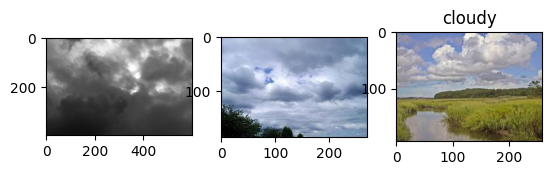

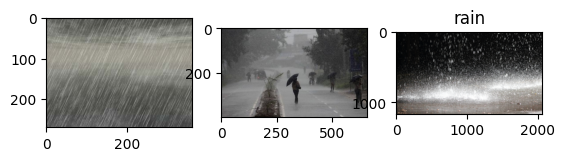

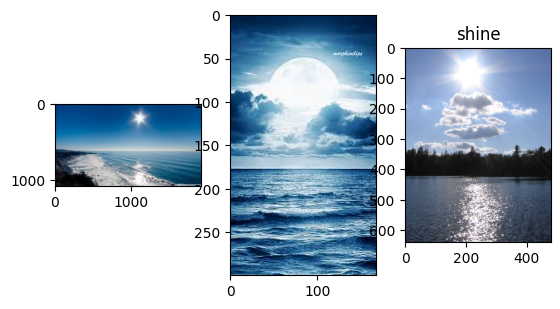

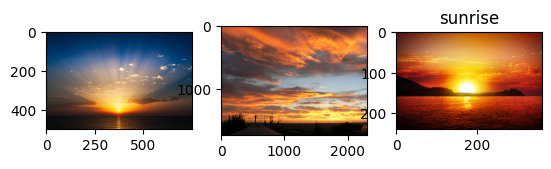

In [40]:
for label_name in LABELS_LIST:
    mask = img_df["label_name"]==label_name
    image_path_list = img_df[mask].reset_index().loc[0:2, "image_path"]
    for i in range(3):
        image = imread(image_path_list[i])  
        plt.subplot(131 + i)
        plt.imshow(image)
    plt.title(label_name)
    plt.show() 

## Feature extraction

### Création du modèle pré-entraîné

<font color="purple">Charger le modèle VGG16 de tensorflow.keras.applications.vgg16.</font> Pour plus de renseignements sur l'architecture de VGG16, il est possible de consulter par exemple la ressource suivante : https://datacorner.fr/vgg-transfer-learning/.

In [41]:
base_model = VGG16()

<font color="purple">Afficher les 5 dernières couches du modèle à l'aide de .layers.</font>

In [42]:
display(base_model.layers[-5:])

L'ouput n'est pas très lisible. <font color="purple">Afficher un résumé de l'architecture du modèle avec .summary().</font>

In [43]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

<font color="purple">Construire un nouveau modèle à partir du modèle VGG16 amputé de toutes ses n-1 dernières couches Dense, où n désigne le nombre de couches Dense successives en aval du modèle.</font> Pour cela, utiliser instancier un objet de la classe Model du module tensorflow.keras.models, en passant comme arguments du constructeurs :
- inputs: les inputs du modèle VGG16,
- outputs: le résultat de l'appel de .output sur la liste des couches du modèle VGG16 amputé des n-1 dernières couches.

<font color="purple">Afficher un résumé de l'architecture du modèle.</font>

In [44]:
model = Model(inputs=base_model.inputs, outputs=base_model.layers[-2].output)
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

## Création des features des images

<font color="purple">Préparer une fonction prenant en entrée le chemin vers une image et renvoyant les features extraites grâce au modèle, en appliquant les étapes successives suivantes :</font>
- chargement de l'image à l'aide de la fonction load_img de tensorflow.keras.preprocessing.image, en fixant une taille de 224x224,
- conversion en array à l'aide de la fonction img_to_array de tensorflow.keras.preprocessing.image également,
- ajout d'un axe à partir de l'axe 0 à l'aide de la fonction expand_dims de numpy (pour en visualiser l'utilité, essayer de commenter la ligne dans la fonction et constater l'erreur lors de l'appel sur une image),
- prétraitement pour normaliser le tableau représentant l'image avec la fonction standard preprocess_input de tensorflow.keras.applications.vgg16 (sans se poser plus de questions : les modèles keras viennent généralement avec leur fonction de prétraitement des images adaptées de manière spécifique au modèle en question),
- prédiction des features à partir de la méthode predict du modèle.

Il est à noter qu'il n'est pas classique d'avoir un predict dans une fonction "préparatoire". Ici nous nous le permettons car l'extraction de feature est préparatoire au X qui retendra dans le modèle de segmentation. Lorsque nous utiliserons notre CNN pour réaliser la classification complète, nous sortirons cet appel de la préparation des données.

In [45]:
def extract_features(image_path: str, model: Predictor) -> np.array:
    """Extract features from an image given its path."""
    img_array = img_to_array(load_img(image_path, target_size=(224, 224)))
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return model.predict(img_array, verbose=False)[0]

<font color="purple">Appliquer cette fonction à l'ensemble du dataset ligne par ligne. Convertir le résultat en array numpy de taille nombre d'images x nombre de features à l'aide de la fonction np.stack (appliquer auparavant .values sur les features extraites).</font>

In [60]:
all_features = img_df["image_path"].apply(lambda image_path: extract_features(
    image_path=image_path, model=model))
all_features_array = np.stack(all_features)

<font color="purple">Afficher la taille de ce tableau.</font>

In [62]:
all_features_array.shape

(1125, 4096)

## Réduction de dimension

### Réduction de dimension via ACP pour l'extraction même de features

<font color="purple">Appliquer une simple ACP pour réduire la dimension de l'image. Choisir par exemple de conserver un nombre de composantes tel que la quantité de variance expliquée soit supérieure à 99%. Vérifier la taille du tableau de features en sortie de l'ACP.</font>

In [64]:
pca = PCA(n_components=0.99)
feat_pca_array = pca.fit_transform(all_features_array)
print(feat_pca_array.shape)

(1125, 706)


### Réduction de dimension T-SNE pour la visualisation

<font color="purple">Projeter les features en dimension 2 pour la visualisation, grâce à un TSNE. Consulter la documentation de ce modèle.</font>

In [67]:
tsne = TSNE(n_components=2, perplexity=30, n_iter=2000, init="random", random_state=6)
X_tsne = tsne.fit_transform(feat_pca_array)

<font color="purple">Reformer un dataframe contenant l'ensemble des features post-TSNE ainsi qu'une dernière colonne contenant le label. En afficher un échantillon aléatoire de taille 10.</font>

In [68]:
tsne_df = pd.DataFrame(data=X_tsne, columns=["tsne_one", "tsne_two"])
tsne_df["class"] = img_df["label_name"]
tsne_df.sample(10)

,tsne_one,tsne_two,class
195,-8.200953,18.175949,cloudy
567,19.195206,11.821418,shine
491,-55.907616,21.661789,rain
1054,39.011745,21.917023,sunrise
406,-39.239223,-1.956562,rain
529,-0.165615,-31.799826,shine
399,-45.594620,4.029159,rain
334,-17.487530,13.564256,rain
910,31.390974,5.746430,sunrise
1041,43.895653,0.256675,sunrise


Voici une fonction (nous la réutiliserons plus tard) permettant d'afficher le nuage de points des individus sur l'espace de projection de dimension (cette fois en combinant plt avec un scatterplot seaborn, pour varier les plaisirs).

Même si nous n'utiliserons pas les vraies classes pour segmenter ce nuage de points, nous affichons avec des couleurs différentes les points ayant des labels différents à fin purement informative. Le nom de la colonne du dataframe à partir de laquelle colorer les points est un argument d'entrée de notre fonction d'affichage.

In [69]:
def create_tsne_viz(tsne_df: pd.DataFrame, hue_col: str) -> None:
    plt.figure(figsize=(10,5))
    sns.scatterplot(
        tsne_df,
        x="tsne_one",
        y="tsne_two",
        hue=hue_col,
    )
    plt.title(f"TSNE et visualisation - {hue_col}.")
    plt.xlabel("Première composante")
    plt.ylabel("Seconde composante")
    plt.show()

<font color="purple">Appeler cette fonction sur notre jeu de données :</font>

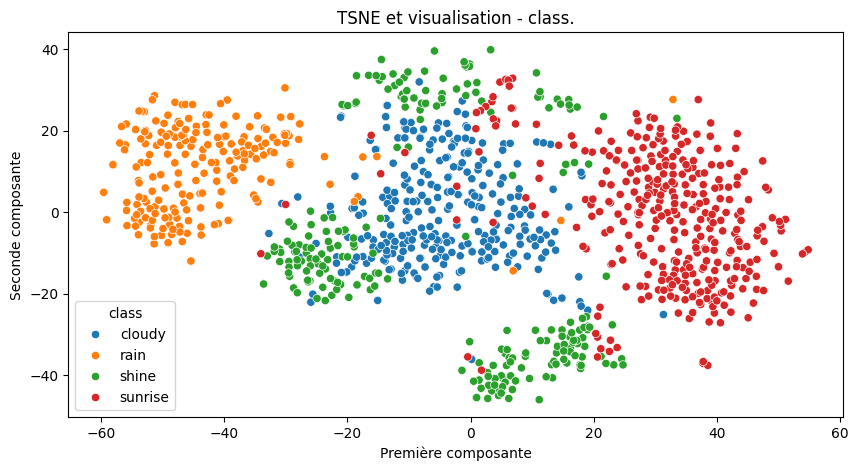

In [71]:
create_tsne_viz(tsne_df=tsne_df, hue_col="class")

Quelques interprétations :
- L'analyse graphique donne des indices visuels quand à la faisabilité de la séparation automatique des images selon leurs vraies classes -> se faire une idée sur la question. Cela permet d'estimer la faisabilité de réaliser ultérieurement une classification supervisée pour déterminer automatiquement les classes des images.
- Cette étape est plutôt rapide à réaliser, notamment parce qu'elle ne demande l'entraînement de task nets. Une conclusion négative sur la faisabilité peut permettre d'éviter de réaliser des traitements plus lourds. Cela permet également de discuter du caractère "naturel" du découpage en labels déjà effectué (il serait peut-être possible de découper ce même dataset en 4 groupes plus isolés, sur la base de l'extraction de features effectuées).
- On peut image que cette démarche en plusieurs étapes s'inscrive dans la démarche agile d'un projet data.

### Clustering

Il s'agit ici de conforter simplement, par une mesure de l'ARI, l'analyse graphique précédente qui semble montrer la faisabilité relative d'une classification supervisée, avec des difficultés à prévoir pour segmenter les images "shine". Cette mesure de l'ARI nécessite de créer des clusters théoriques.
Pour réaliser une mesure de ce que nous voyons graphiquement, il faut partir des données en sorties du t-SNE. Pour toute autre application (classification ou segmentation réelle des images), il faudra repartir des features extraites par l'ensemble des étapes dédiées à cela, c'est-à-dire en sortie de l'ACP mais en amont du t-SNE.
Le score ARI est lié aux labels des données ; aussi rien ne garantit que la "meilleure" solution de feature engineering, si tant est qu'elle existe, sera celle qui génère le meilleur ARI.


Nous faisons ici le choix de mettre en oeuvre l'algorithme K-means. <font color="purple">Mettre en oeuvre un tel modèle en fixant un nombre de clusters égal au nombre de classes anticipé (4).</font> Il est possible de repartir de la sortie de l'ACP ou de celle du t-SNE (à discuter).

In [73]:
cls = KMeans(n_clusters=4, n_init="auto", random_state=0)
cls.fit(X_tsne)

KMeans(n_clusters=4, n_init='auto', random_state=0)

<font color="purple">Ajouter au dataframe des données extraites pour l'ACP ou le t-SNE une colonne contenant le numéro du cluster affecté par K-means. En afficher un échantillon aléatoire de taille 10.</font>

In [75]:
tsne_df["cluster"] = cls.labels_
tsne_df.sample(10)

,tsne_one,tsne_two,class,cluster
1071,53.916508,-10.212521,sunrise,2
1064,23.968672,-0.450458,sunrise,2
1066,22.721727,2.317866,sunrise,2
605,-5.511953,26.074385,shine,0
759,-1.387708,-38.784821,shine,1
100,-11.056780,-16.656326,cloudy,1
318,-53.937218,7.767478,rain,3
392,-58.085537,11.681938,rain,3
763,1.000883,-45.461933,shine,1
78,-13.563196,-10.461049,cloudy,1


<font color="purple">Effectuer à l'oeil une correspondance (bijective) entre les classes et les clusters (il est bien entendu possible d'automatiser la recherche d'une telle correspondance maximisant la métrique de similarité, mais ici, cela peut être réalisé visuellement).</font>

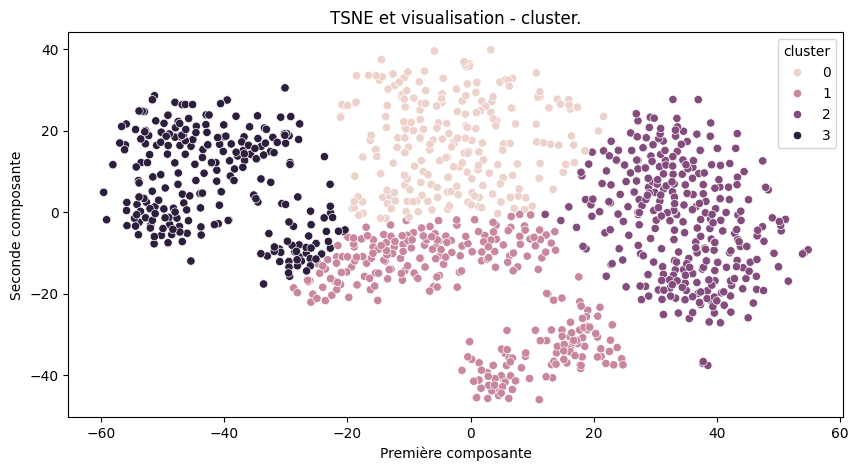

In [77]:
create_tsne_viz(tsne_df=tsne_df, hue_col="cluster")

In [79]:
cluster_class_map = {
    0: "cloudy",
    1: "shine",
    2: "sunrise",
    3: "rain",
}

<font color="purple">Dénombrer le nombre d'images shine affectées au cluster cloudy.</font>

In [80]:
mask = (tsne_df["class"]=="shine") & (tsne_df["cluster"]==0)
mask.sum()

80

<font color="purple">Afficher une image shine considérée comme cloudy par le clustering. Essayer d'interpréter d'où peut venir la confusion (si possible).</font>

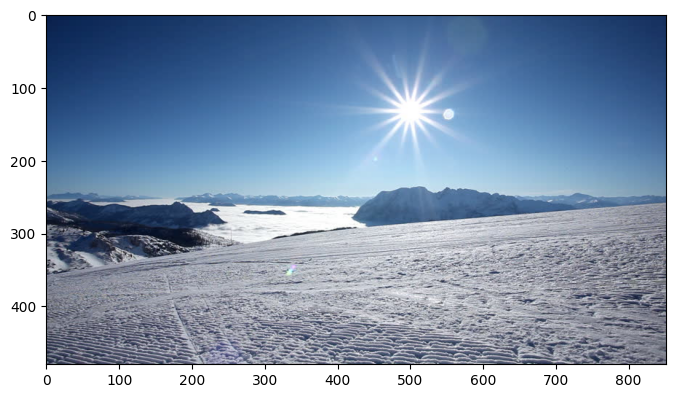

In [81]:
filename = img_df[mask].reset_index().loc[3, "image_path"]
img = imread(filename)
plt.figure(figsize = (8, 5))
plt.imshow(img)
plt.show()

Selon les images obtenues, la confusion peut venir de la présence de neige interprétée comme des nuages, la présence d'un ciel nuageux sans pluie avec du soleil, la présence d'un autre élément remarquable mais non indicateur de la classe (par exemple l'océan), la présence de features "non robustes" telles qu'une colorimétrie très particulière de l'image... Il est aussi possible de tomber sur une image pour laquelle la cause de la confusion n'est pas apparente à l'oeil humain !

Il est désormais temps d'avoir une analyse un peu plus globale des éléments cohérents et de la confusion.

### Analyse par classes

<font color="purple">A l'aide de la fonction confusion_matrix du module metrics de scikit-learn, afficher la matrice de confusion brute de notre problème. Veiller à bien réaligner les classes et les clusters. Une fois la matrice brute obtenue, appeler la fonction de la cellule suivante pour améliorer le visuel.</font>

In [84]:
cluster_labels = list(map(cluster_class_map.get, tsne_df["cluster"]))

conf_mat = confusion_matrix(
    y_true=tsne_df["class"],
    y_pred=cluster_labels,
    labels=LABELS_LIST,
)

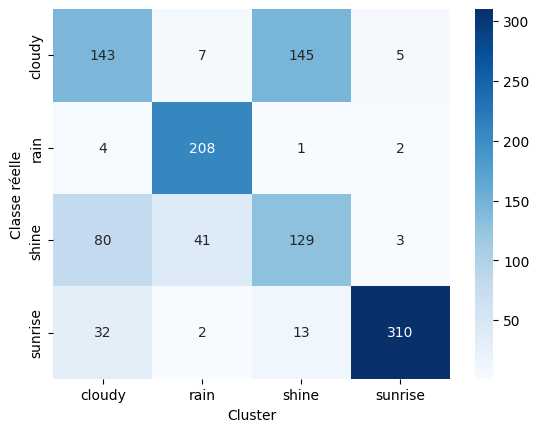

In [85]:
sns.heatmap(
    conf_mat,
    annot=True,
    fmt="g",
    cmap="Blues",
    xticklabels=LABELS_LIST,
    yticklabels=LABELS_LIST,
)
plt.xlabel("Cluster")
plt.ylabel("Classe réelle")
plt.show()

<font color="purple">Générer également un "rapport de classification" (toujours à partir du module metrics de scikit-learn).</font>

In [87]:
print(classification_report(y_true=tsne_df["class"], y_pred=cluster_labels))

              precision    recall  f1-score   support

      cloudy       0.55      0.48      0.51       300
        rain       0.81      0.97      0.88       215
       shine       0.45      0.51      0.48       253
     sunrise       0.97      0.87      0.92       357

    accuracy                           0.70      1125
   macro avg       0.69      0.71      0.70      1125
weighted avg       0.71      0.70      0.70      1125



<font color="purple">Pour terminer, calculer une mesure de similarité globale telle que le ARI score. Une fonction permettant de le calculer directement est (bien entendu) disponible dans scikit-learn. A votre avis, dans quel module ?</font> Rechercher sur Internet la fonction exacte à utiliser.

In [90]:
adjusted_rand_score(
    labels_true=tsne_df["class"],
    labels_pred=cluster_labels,
)

0.5149348873439661

<font color="purple">Cette fonction est-elle symétrique ? (Peut-on inverser valeurs réelles et prédites ?)</font>

In [92]:
# Oui

<font color="purple">Nous arrivons à la fin de la première partie. Avant de tout casser avec des bêtises, c'est peut-être le moment de sauvegarder les variables d'intérêt. Choisir les variables les plus importantes et les sauvegarder dans le dossier courant au format pickle.</font>

In [93]:
with open("img_df.pkl", "wb") as handle:
    pkl.dump(img_df, handle)
with open("features_array.pkl", "wb") as handle:
    pkl.dump(feat_pca_array, handle)

# TEMPS 2 : CLASSIFICATION

<font color="orange">En repartant du code précédent pour cette étape, écrire le prétraitement que suivra cette image, en supprimant l'inférence par le modèle. </font> Pour rappel, les étapes suivantes seront les suivantes :
- charger l'image avec la fonction load_img du module tensorflow.keras.preprocessing.image, en utilisant l'argument target_size pour forcer une redimension fixée à 224x224,
- convertir l'image en array avec la fonction img_to_array de ce même module,
- appliquer la fonction de préprocessing déjà prête de VGG16 : preprocess_input du module tensorflow.keras.applications.vgg16.

In [94]:
def prepare_image(image_path: str) -> np.array:
    """Extract features from an image given its path."""
    img_array = img_to_array(load_img(image_path, target_size=(224, 224)))
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array

<font color="orange">Si ce n'est pas déjà fait, à partir du traitement unitaire écrit précédemment, écrire la fonction prenant en entrée notre dataframe et créant le tableau de toutes les images contenues dans le dataframe (dans l'ordre).</font>

<font color="orange">Appeler cette fonction sur notre dataframe d'images.</font> Ce traitement peut prendre du temps.

In [95]:
X = img_df['image_path'].apply(prepare_image)
X = np.stack(X)
X = np.squeeze(X, axis=1)

<font color="orange">Préparer le vecteur y en appelant to_categorical sur la colonne contenant le label (numérique).</font>

In [97]:
y = to_categorical(img_df['label'])

<font color="orange">Séparer le jeu de données en un jeu d'entraînement et un jeu de test. Fixer un random_state pour garantir la reproductibilité des résultats pendant la phase d'élaboration de notre modèle. Stratifier selon la cible.</font>

In [99]:
X_macro_train, X_test, y_macro_train, y_test = train_test_split(
    X,
    y,
    stratify=y,
    test_size=0.2,
    random_state=0,
)

Remarque : généralement cette étape est effectuée AVANT tout autre traitement afin d'éviter tout data leakage. Pour autant, ici, la fonction de préprocessing s'applique aux images de façon unitaire (le traitement d'un image n'est pas dépendant des autres images), et, étant donné la stratification, toutes les classes du référentiel seront nécessairement représentées dans le jeu d'entraînement et dans celui de test, de sorte que l'encoding de la cible dans le jeu de test ne révèlera pas de surprise de type modalité inconnue.

<font color="orange">Redécouper le jeu d'entraînement en mini-jeu d'entraînement et jeu de validation.</font>

In [100]:
X_train, X_val, y_train, y_val = train_test_split(
    X_macro_train,
    y_macro_train,
    stratify=y_macro_train,
    test_size=0.2,
    random_state=0,
)

### Préparation du modèle

<font color="orange">Ecrire une fonction permettant de créer notre modèle VGG16.</font> Pour cela, en s'inspirant du début de travail déjà réalisé dans la partie segmentation :
- instancier un objet VGG16. A partir de la doc, faire en sorte d'initialiser les points à ceux du modèle pré-entraîné sur le jeu ImageNet. Choisir par exemple de ne pas inclure les 3 premières couches fully-connected, et spécifier dans ce cas une taille d'entrée de 224x224x3
- indiquer que toutes ces couches seront "gelées" (non entraînables). Pour cela, boucler sur l'ensemble des éléments de model.layers et définir l'attribut trainable à False.
- stocker dans une variable model.output, puis ajouter une couche de pooling, une couche dense, une couche de dropout et une dernière couche dense.
- définir le nouveau modèle et le compiler.

In [154]:
IMG_SIZE = 224

In [ ]:
def create_model(num_categories):
    """Create a model from the VGG16 model, adding a task head for image
    classification.
    """
    # Récupération modèle pré-entraîné
    model0 = VGG16(include_top=False, weights="imagenet", input_shape=(IMG_SIZE, IMG_SIZE, 3))

    # Layer non entraînables = on garde les poids du modèle pré-entraîné
    for layer in model0.layers:
        layer.trainable = False

    # Récupérer la sortie de ce réseau
    x = model0.output
    # Compléter le modèle
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_categories, activation='softmax')(x)

    # Définir le nouveau modèle
    model = Model(inputs=model0.input, outputs=predictions)
    # compilation du modèle 
    model.compile(loss="categorical_crossentropy", optimizer='rmsprop', metrics=["accuracy"])

    print(model.summary())
    
    return model


In [ ]:
def other_create_model(num_categories):
    # Récupération modèle pré-entraîné
    base_model = VGG16(include_top=False, weights="imagenet", input_shape=(IMG_SIZE, IMG_SIZE, 3))

    # Layer non entraînables = on garde les poids du modèle pré-entraîné
    for layer in base_model.layers:
        layer.trainable = False
    
    model = Sequential([
                base_model,
                GlobalAveragePooling2D(),
                Dense(256, activation='relu'),
                Dropout(0.5),
                Dense(num_categories, activation='softmax')
                ])

    # compilation du modèle
    loss = "categorical_crossentropy"
    optimizer = 'adam'
    model_metrics = ["accuracy"]

    model.compile(loss=loss, optimizer=optimizer, metrics=model_metrics)

    print(model.summary())

    return model

<font color="orange">Créer effectivement le modèle, avec un context manager spécifiant le device à utiliser (c'est ici qu'on spécifierait quel GPU utiliser si on en disposer). Dans notre cas, utilisons "/cpu:0"</font>

In [ ]:
with tf.device("/cpu:0"): 
    model1 = create_model(num_categories=4)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

<font color="orange">Créer un "callback" pour créer un early stopping de la manière suivante et sauvegarder le modèle de la manière suivante :</font>

In [108]:
model1_save_path1 = "./model1_best_weights.h5"
checkpoint = ModelCheckpoint(model1_save_path1, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=1)
callbacks_list = [checkpoint, es]

<font color="orange">A l'intérieur du context manager spécifiant le device à utiliser, lancer l'entraînement du modèle. Prévoir dès maintenant de sauvegarder la sortie dans une variable appelée history (nous l'utiliserons plus tard). Attention à bien préciser le jeu de validation ! </font>

In [109]:
with tf.device('/cpu:0'): 
    history1 = model1.fit(
        X_train,
        y_train,
        epochs=2,
        batch_size=64,
        callbacks=callbacks_list,
        validation_data=(X_val, y_val),
        verbose=1,
    )


Epoch 1/2
12/12 [==============================] - ETA: 0s - loss: 0.7571 - accuracy: 0.7819 
Epoch 1: val_loss improved from inf to 0.25196, saving model to .\model1_best_weights.h5


c:\Users\bspeziale\AppData\Local\pypoetry\Cache\virtualenvs\test-yOZBwoax-py3.11\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


12/12 [==============================] - 174s 15s/step - loss: 0.7571 - accuracy: 0.7819 - val_loss: 0.2520 - val_accuracy: 0.9222
Epoch 2/2
12/12 [==============================] - ETA: 0s - loss: 0.4906 - accuracy: 0.8694 
Epoch 2: val_loss did not improve from 0.25196
12/12 [==============================] - 153s 13s/step - loss: 0.4906 - accuracy: 0.8694 - val_loss: 0.3074 - val_accuracy: 0.9111
Epoch 2: early stopping


<font color="orange">Vérifier le score du dernier epoch sur le jeu d'entraînement et le jeu de validation grâce à la méthode evaluate de notre modèle entraîné.</font>

In [110]:
loss, accuracy = model1.evaluate(X_train, y_train, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy))
print()
loss, accuracy = model1.evaluate(X_val, y_val, verbose=True)
print("Validation Accuracy: {:.4f}".format(accuracy))

23/23 [==============================] - 244s 11s/step - loss: 0.1031 - accuracy: 0.9667
Training Accuracy: 0.9667

6/6 [==============================] - 50s 8s/step - loss: 0.3074 - accuracy: 0.9111
Validation Accuracy: 0.9111


<font color="orange">Vérifier le score de l'epoch optimal sur le jeu de validation et le jeu de test.</font>

In [111]:
model1.load_weights(model1_save_path1)

loss, accuracy = model1.evaluate(X_val, y_val, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))

loss, accuracy = model1.evaluate(X_test, y_test, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy))

Validation Accuracy :  0.9222
Test Accuracy       :  0.8978


<font color="orange">Consulter la doc de plot_keras_history. A partir de celle-ci, visualiser l'évolution de la loss et de l'accuracy au fil des epochs.</font>

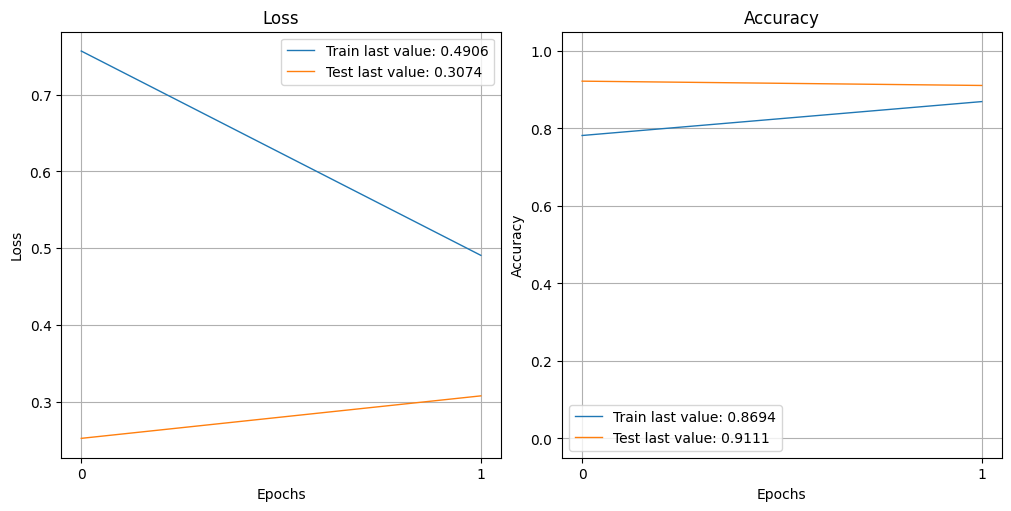

In [117]:
show_history(history1)
plot_history(history1, path="standard.png")
plt.close()

<font color="orange">Afficher les classes réelles et prédites sur les images du jeu de validation.</font>

In [118]:
y_val_num = np.argmax(y_val, axis=1)
y_val_pred = np.argmax(model1.predict(X_val), axis=1)

print(y_val_num)
print(y_val_pred)

6/6 [==============================] - 58s 10s/step
[2 0 3 2 2 0 2 2 0 0 0 2 0 2 2 3 3 3 2 1 2 3 0 2 1 3 0 0 3 0 2 2 2 1 3 0 1
 1 0 0 1 3 2 0 3 3 1 1 0 3 2 3 3 0 1 0 2 3 1 0 0 3 3 3 1 3 3 0 3 1 3 1 2 2
 0 2 3 2 1 0 1 2 0 3 2 1 1 2 2 0 1 1 1 0 3 0 3 0 3 2 3 0 3 0 3 1 0 2 3 3 0
 2 3 0 3 3 0 2 3 3 1 1 1 2 3 3 0 0 3 3 0 1 3 0 2 2 3 2 1 2 1 1 3 0 3 0 0 0
 3 2 3 3 3 1 0 1 0 1 3 1 1 0 3 3 2 0 0 3 0 2 3 3 2 1 2 2 0 3 3 2]
[2 0 3 2 2 2 2 2 2 0 0 2 0 2 2 3 3 3 2 1 0 3 0 2 1 3 0 0 3 0 2 2 2 1 3 0 1
 1 0 0 1 3 2 0 3 3 2 1 0 3 2 3 3 0 1 0 2 2 1 0 3 3 3 3 1 3 3 0 3 1 3 1 2 2
 0 2 3 3 1 3 1 2 0 3 2 1 1 2 2 1 1 1 1 0 3 0 3 3 3 2 3 0 3 0 3 1 0 2 3 2 0
 2 3 0 3 3 0 2 3 3 1 1 1 2 3 3 2 0 3 3 0 1 0 0 2 2 3 2 1 3 1 1 3 0 3 0 0 0
 3 2 3 3 3 1 0 1 0 1 3 1 1 0 3 3 2 0 0 3 0 2 3 3 2 1 2 2 0 3 3 2]


<font color="orange">De manière analogue à la section précédente, afficher la matrice de confusion associée ainsi que le rapport de classification.</font>

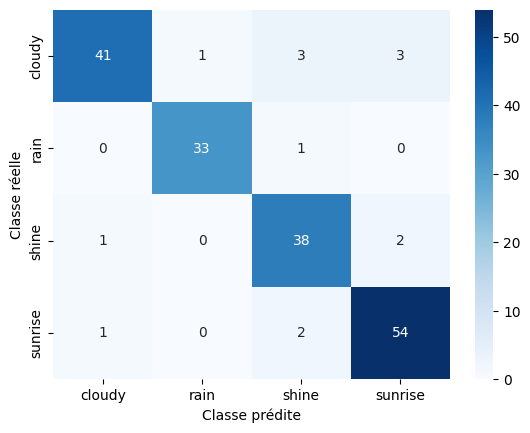

In [119]:
conf_mat = confusion_matrix(
    y_true=y_val_num,
    y_pred=y_val_pred,
)

sns.heatmap(
    data=conf_mat,
    annot=True,
    cmap="Blues",
    fmt="g",
    xticklabels=LABELS_LIST,
    yticklabels=LABELS_LIST,
)
plt.xlabel("Classe prédite")
plt.ylabel("Classe réelle")
plt.show()

In [120]:
print(classification_report(y_val_num, y_val_pred))

              precision    recall  f1-score   support

           0       0.95      0.85      0.90        48
           1       0.97      0.97      0.97        34
           2       0.86      0.93      0.89        41
           3       0.92      0.95      0.93        57

    accuracy                           0.92       180
   macro avg       0.93      0.92      0.92       180
weighted avg       0.92      0.92      0.92       180



<font color="orange">Essayer éventuellement de visualiser les prédictions sur les images de test. <br> Il serait en particulier intéressant de voir la prédiction du modèle sur des images présentant des écueils soulevés dans la section précédente (par exemple des images avec de la neige) qui n'auraient pas été utilisées dans le jeu d'entraînement, s'il y en a.</font>

In [137]:
def prepare_images(img_df: pd.DataFrame) -> np.ndarray:
    prepared_images = []
    for image_num in range(len(img_df['image_path'])):
        img = (load_img(
            img_df['image_path'][image_num],
            target_size=(224, 224),
        ))
        img = img_to_array(img)
        img = preprocess_input(img)
        prepared_images.append(img)
        prepared_images_np = np.array(prepared_images)
    return prepared_images_np

In [142]:
def make_predictions(paths):
    import os
    img_df = pd.DataFrame(
        {
            "image_path": [
                os.path.join(os.getcwd(), path)
                for path in paths
            ]
        }
    )
    X = prepare_images(img_df=img_df)
    y_proba_pred = model1.predict(X)
    y_class_pred = np.argmax(model1.predict(X), axis=1)
    y_class_pred = np.array([LABELS_LIST[i] for i in y_class_pred])
    return y_class_pred, y_proba_pred


In [148]:
make_predictions([
    "rain_test.jpg",
    "piece.png"
])

1/1 [==============================] - 0s 321ms/step


(array(['rain', 'rain'], dtype='<U4'),
 array([[1.1541603e-12, 1.0000000e+00, 2.0119186e-08, 1.9675376e-11],
        [2.4557261e-05, 9.9982733e-01, 1.2365590e-06, 1.4691267e-04]],
       dtype=float32))

In [145]:
with open("weather-classification-model.pkl", "rb") as handle:
    new_model = pkl.load(handle)

In [147]:
img_df = pd.DataFrame(
        {
            "image_path": [
                os.path.join(os.getcwd(), path)
                for path in [
    "rain_test.jpg",
]
            ]
        }
    )
X = prepare_images(img_df=img_df)
new_model.predict(X)

1/1 [==============================] - 0s 405ms/step


array([[1.1541515e-12, 1.0000000e+00, 2.0119071e-08, 1.9675263e-11]],
      dtype=float32)

In [144]:
with open("weather-classification-model.pkl", "wb") as handle:
    pkl.dump(model1, handle)

### Data augmentation (intégrée au modèle)

Une ressource utile est celle de tensorflow sur la data augmentation, située à l'adresse suivante : https://www.tensorflow.org/tutorials/images/data_augmentation

Grâce au tutorial (première méthode), créer une data augmentation contenant RandomFlip, RandomRotation et RandomZoom.

In [ ]:
def create_model_with_data_augmentation(num_categories):

    # Data augmentation
    data_augmentation = Sequential([
        RandomFlip("horizontal", input_shape=(IMG_SIZE, IMG_SIZE, 3)),
        RandomRotation(1),
        RandomZoom((-0.1, 0.1)),
    ])

    # Récupération modèle pré-entraîné
    base_model = VGG16(include_top=False, weights="imagenet", input_shape=(IMG_SIZE, IMG_SIZE, 3))

    # Layer non entraînables = on garde les poids du modèle pré-entraîné
    for layer in base_model.layers:
        layer.trainable = False
    
    model = Sequential([
                data_augmentation,
                base_model,
                GlobalAveragePooling2D(),
                Dense(256, activation='relu'),
                Dropout(0.5),
                Dense(num_categories, activation='softmax')
                ])

    # compilation du modèle
    loss = "categorical_crossentropy"
    optimizer = 'adam'
    model_metrics = ["accuracy"]

    model.compile(loss=loss, optimizer=optimizer, metrics=model_metrics)

    return model

<font color="orange">Reprendre l'ensemble des questions précédentes de la partie CLASSIFICATION et comparer les deux modèles.</font>

In [ ]:
with tf.device("/cpu:0"): 
    model2 = create_model_with_data_augmentation(num_categories=4)

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_8 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_5  (None, 512)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_10 (Dense)            (None, 256)               131328    
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                                 
 dense_11 (Dense)            (None, 4)                 1028      
                                                      